<a href="https://colab.research.google.com/github/arishp/srm-ap-genai-2024/blob/main/05_Multi_Agent_Essay_Writer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install langgraph
# !pip install langchain-groq
# !pip install tavily-python

In [50]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from pydantic import BaseModel
from langchain_groq import ChatGroq
from google.colab import userdata
from tavily import TavilyClient

In [51]:
groq_key=userdata.get("GROQ_API_KEY")
tavily_key = userdata.get("TAVILY_API_KEY")

In [42]:
class AgentState(TypedDict):
    task: str
    lnode: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    queries: List[str]
    revision_number: int
    max_revisions: int
    count: Annotated[int, operator.add]

In [43]:
class Queries(BaseModel):
    queries: List[str]

In [52]:
class ewriter():
    def __init__(self):
        self.model=ChatGroq(api_key=groq_key, model_name="Gemma2-9b-It")
        self.PLAN_PROMPT = ("You are an expert writer tasked with writing a high level outline of a short 3 paragraph essay. "
                            "Write such an outline for the user provided topic. Give the three main headers of an outline of "
                             "the essay along with any relevant notes or instructions for the sections. ")
        self.WRITER_PROMPT = ("You are an essay assistant tasked with writing excellent 3 paragraph essays. "
                              "Generate the best essay possible for the user's request and the initial outline. "
                              "If the user provides critique, respond with a revised version of your previous attempts. "
                              "Utilize all the information below as needed: \n"
                              "------\n"
                              "{content}")
        self.RESEARCH_PLAN_PROMPT = ("You are a researcher charged with providing information that can "
                                     "be used when writing the following essay. Generate a list of search "
                                     "queries that will gather "
                                     "any relevant information. Only generate 3 queries max.")
        self.REFLECTION_PROMPT = ("You are a teacher grading an 3 paragraph essay submission. "
                                  "Generate critique and recommendations for the user's submission. "
                                  "Provide detailed recommendations, including requests for length, depth, style, etc.")
        self.RESEARCH_CRITIQUE_PROMPT = ("You are a researcher charged with providing information that can "
                                         "be used when making any requested revisions (as outlined below). "
                                         "Generate a list of search queries that will gather any relevant information. "
                                         "Only generate 2 queries max.")
        self.tavily = TavilyClient(api_key=tavily_key)
        builder = StateGraph(AgentState)
        builder.add_node("planner", self.plan_node)
        builder.add_node("research_plan", self.research_plan_node)
        builder.add_node("generate", self.generation_node)
        builder.add_node("reflect", self.reflection_node)
        builder.add_node("research_critique", self.research_critique_node)
        builder.set_entry_point("planner")
        builder.add_conditional_edges(
            "generate",
            self.should_continue,
            {END: END, "reflect": "reflect"}
        )
        builder.add_edge("planner", "research_plan")
        builder.add_edge("research_plan", "generate")
        builder.add_edge("reflect", "research_critique")
        builder.add_edge("research_critique", "generate")
        memory = MemorySaver()
        self.graph = builder.compile(
            checkpointer=memory,
            # interrupt_after=['planner', 'generate', 'reflect', 'research_plan', 'research_critique']
        )

    def plan_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ]
        response = self.model.invoke(messages)
        return {"plan": response.content,
               "lnode": "planner",
                "count": 1,
               }
    def research_plan_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ])
        content = state['content'] or []  # add to content
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
                "queries": queries.queries,
               "lnode": "research_plan",
                "count": 1,
               }
    def generation_node(self, state: AgentState):
        content = "\n\n".join(state['content'] or [])
        user_message = HumanMessage(
            content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
        messages = [
            SystemMessage(
                content=self.WRITER_PROMPT.format(content=content)
            ),
            user_message
            ]
        response = self.model.invoke(messages)
        return {
            "draft": response.content,
            "revision_number": state.get("revision_number", 1) + 1,
            "lnode": "generate",
            "count": 1,
        }
    def reflection_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.REFLECTION_PROMPT),
            HumanMessage(content=state['draft'])
        ]
        response = self.model.invoke(messages)
        return {"critique": response.content,
               "lnode": "reflect",
                "count": 1,
        }
    def research_critique_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state['critique'])
        ])
        content = state['content'] or []
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
               "lnode": "research_critique",
                "count": 1,
        }
    def should_continue(self, state):
        if state["revision_number"] > state["max_revisions"]:
            return END
        return "reflect"

In [53]:
MultiAgent = ewriter()

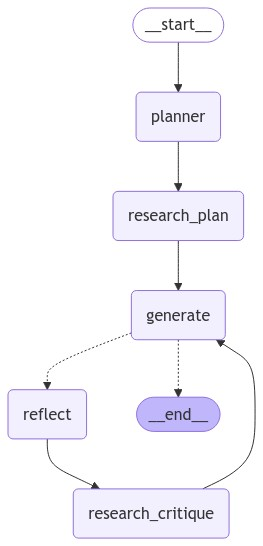

In [54]:
from IPython.display import Image, display

try:
    display(Image(MultiAgent.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
topic = 'pizza shop'
initial_input = {'task': topic,"max_revisions": 2,"revision_number": 0,
                 'lnode': "", 'planner': "no plan", 'draft': "no draft", 'critique': "no critique",
                 'content': ["no content",], 'queries': "no queries", 'count':0}
thread = {"configurable": {"thread_id": "1"}}

In [57]:
for s in MultiAgent.graph.stream(initial_input, thread):
    print(s)

{'planner': {'lnode': 'planner', 'plan': "Here's a possible 3-paragraph essay outline about a pizza shop:\n\n**I. Introduction**\n*   Hook: Start with a captivating sentence about the universal appeal of pizza or a personal anecdote about a memorable pizza experience.\n*   Introduce the topic: Briefly mention the significance of pizza shops in communities and their role in providing delicious food and social gathering spaces.\n*   Thesis Statement: State your main argument about pizza shops. This could be about their impact on a community, the evolution of pizza styles, the art of pizza making, or any other interesting aspect you want to explore.\n\n**II. Body Paragraph 1**\n*   **Topic Sentence:**  Elaborate on your thesis statement with a specific point about pizza shops.\n*   Supporting Evidence:  Provide details, examples, and/or anecdotes to support your topic sentence.\n    *   Consider discussing the history of pizza shops, the different types of pizza available, the social aspe